In [1]:
PROJECT_ID = "formazione-riccardo-zanella"
REGION = 'us-central1'
BUCKET_NAME = "bbs-2021-opml4b-explainability"

In [2]:
import tensorflow as tf
import sys

from utils import dataset_to_numpy_util, display_9_images_with_predictions
from serving_utils import numpy_to_b64, predict_json

sys.path.append('../../myproject')
from trainer_image_data.train import load_dataset, get_read_tfrecord

2021-11-18 15:33:25.686080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-18 15:33:25.686123: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
TEST_FILE = 'gs://'+BUCKET_NAME+'/data/image_data/test/flowers06-230.tfrec'

# Load Test dataset

In [4]:
IMAGE_SIZE = [192, 192]
# do not change, maps to the labels in the data (folder names)
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] 
n_classes = len(CLASSES)

In [5]:
images, labels = dataset_to_numpy_util(
    load_dataset([TEST_FILE], get_read_tfrecord(IMAGE_SIZE, n_classes)),
    9
)

2021-11-18 15:33:27.112705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-18 15:33:27.112758: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-18 15:33:27.112776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (INJ-NB-126): /proc/driver/nvidia/version does not exist
2021-11-18 15:33:27.113034: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-18 15:33:27.296310: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Opt

# Get predictions

In [6]:
instances = []
preprocess_name = 'bytes_inputs'

for img in images:
    b64str = numpy_to_b64(img).decode('utf-8')
    instances.append({preprocess_name: {'b64': b64str}})

In [7]:
MODEL = 'flowers'
VERSION = 'v1'
predictions = predict_json(
    PROJECT_ID,
    REGION,
    MODEL, 
    instances,
    version=VERSION)

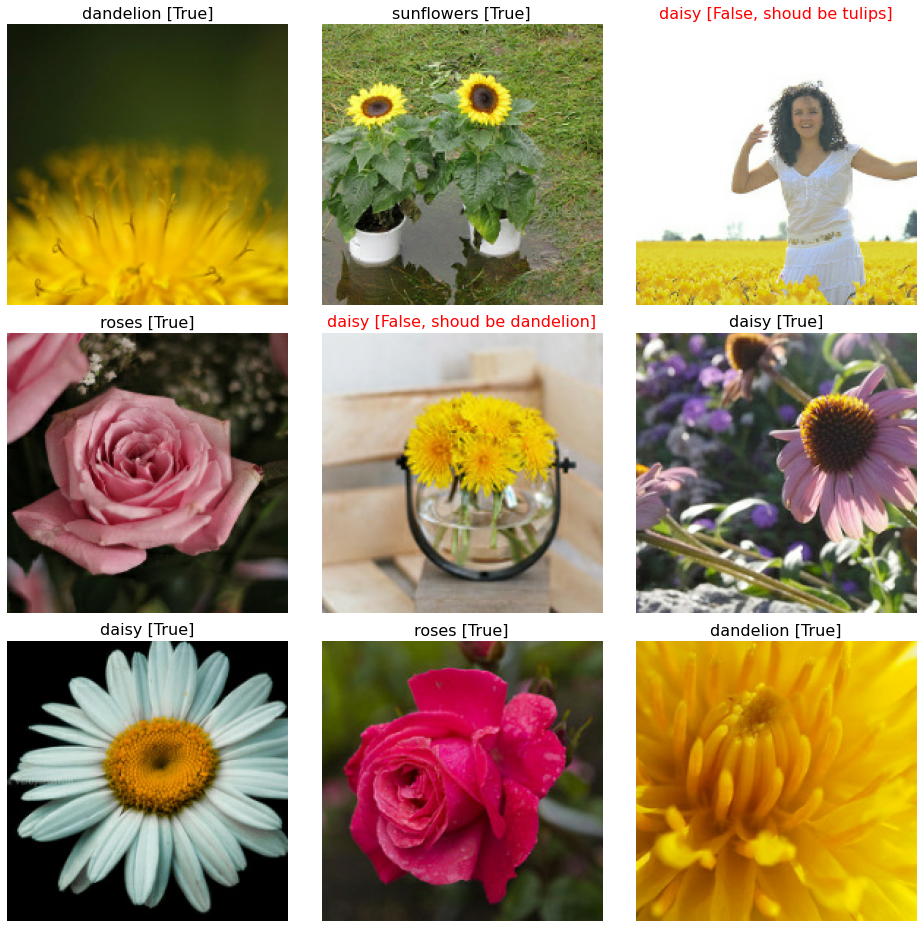

In [8]:
display_9_images_with_predictions(images, predictions, labels, classes=CLASSES)

# Get explanations

Now that your model is deployed, you can use the AI Platform Prediction API to get feature attributions. You'll pass it a single test example here and see which features were most important in the model's prediction. Here you'll use the [Explainable AI SDK](https://pypi.org/project/explainable-ai-sdk/) to get your prediction and explanation. You can also use `gcloud`.

### Send the explain request

You can use the Explainable AI SDK to send explanation requests to your deployed model.

In [9]:
# Format data for prediction to your model
import explainable_ai_sdk
remote_xrai_model = explainable_ai_sdk.load_model_from_ai_platform(PROJECT_ID, MODEL, VERSION, region=REGION)
xrai_response = remote_xrai_model.explain(instances)

true label: sunflowers / model output: sunflowers
Label Index 3
Example Score: 0.6811
Baseline Score: 0.5382
Approximation Error: 0.1589


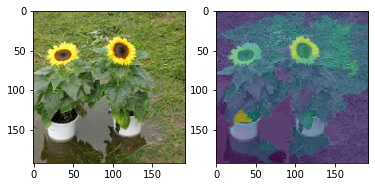

true label: tulips / model output: daisy
Label Index 0
Example Score: 0.4080
Baseline Score: 0.0110
Approximation Error: 0.0646


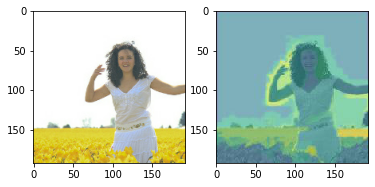

true label: roses / model output: roses
Label Index 2
Example Score: 0.6326
Baseline Score: 0.0045
Approximation Error: 0.0123


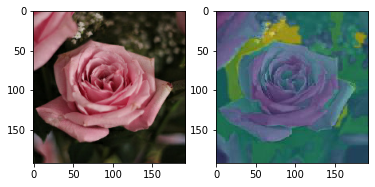

true label: dandelion / model output: daisy
Label Index 0
Example Score: 0.3131
Baseline Score: 0.0110
Approximation Error: 0.0377


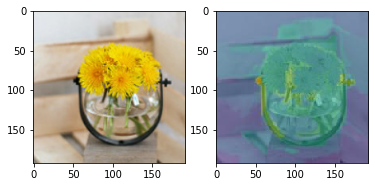

true label: daisy / model output: daisy
Label Index 0
Example Score: 0.3233
Baseline Score: 0.0110
Approximation Error: 0.0183


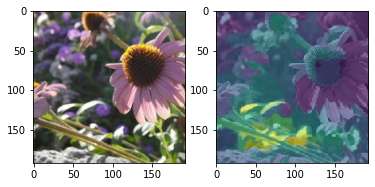

true label: daisy / model output: daisy
Label Index 0
Example Score: 0.6849
Baseline Score: 0.0110
Approximation Error: 0.0150


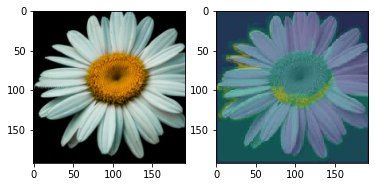

true label: roses / model output: roses
Label Index 2
Example Score: 0.5469
Baseline Score: 0.0045
Approximation Error: 0.0045


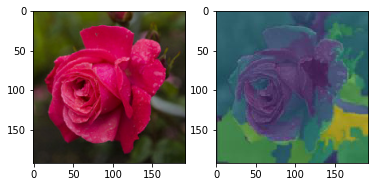

true label: dandelion / model output: dandelion
Label Index 1
Example Score: 0.6059
Baseline Score: 0.4442
Approximation Error: 0.3161


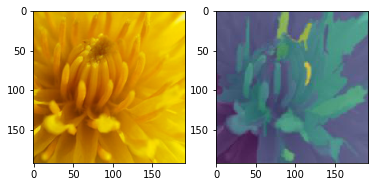

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def compare_print(image: np.ndarray, explanation: explainable_ai_sdk.model.explanation.Explanation) -> None:
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    response.visualize_attributions()

idx = slice(1,9)
for img, lbl, response in zip(images[idx], labels[idx], xrai_response[idx]):
    print('true label: {} / model output: {}'.format(
        CLASSES[np.argmax(lbl)],
        CLASSES[response.get_top_k_indices(1)[0]]
        )
    )
    compare_print(img, response)
    